In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import math

from sympy import Point2D

In [1]:
h = 620
w = 620

def PxltoCoord(x, y, zoom, cntr_lat, cntr_lon):
    parallelMultiplier = math.cos(cntr_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier
    pointLat = cntr_lat - degreesPerPixelY * (y - h / 2)
    pointLng = cntr_lon + degreesPerPixelX * (x - w / 2)

    return [float(pointLat), float(pointLng)]


# Because of non linear transformation (going from pixel to coordinates), function has to be solved for X and Y
def CoordToPixel(pointLat, pointLon, test_lat, test_lon, zoom):
    parallelMultiplier = math.cos(test_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier

    Y = (test_lat - pointLat) / degreesPerPixelY + 0.5 * h
    X = (pointLon - test_lon) / degreesPerPixelX + 0.5 * w
    return X, Y

In [2]:
def find_specific_lookup(data, search_image, template_name):
    for entry in data:
        if entry["search_image"] == search_image:
            for template in entry["templates"]:
                if template["template"] == template_name:
                    return template
    return None

In [4]:
from matplotlib import image as mpimg

#get image pairs
base_path = os.path.dirname(os.getcwd())

#label path
lbl_path = os.path.join(base_path, 'Data/labels/train_template_matching.json')

#source and query images
s_img_path = os.path.join(base_path, 'Data/map_train/51.99908_4.373749.png')
q_img_path = os.path.join(base_path, 'Data/train_template_matching')

#for now source path is constant
s_img = cv2.imread(s_img_path)

with open(lbl_path, 'r') as file:
    label = json.load(file)

images = []
templates = []
print(q_img_path)
for file in os.listdir(q_img_path):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            q_img = cv2.imread(os.path.join(q_img_path, file))
            images.append([q_img[:, :, :3], s_img[:,:,:3]])
            gps = find_specific_lookup(label, '51.99908_4.373749.png', file)

            templates.append((q_img[:, :, :3], gps))

c:\Users\lucah\Documents\hackathon\CASSINI\Data/train_template_matching


In [5]:
def extract_features_for_templates(templates, source_image):
    feature_list = []
    label_list = []

    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)

    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)

        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)

        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        good_matches = good_matches[:100]
        # Extract matched keypoints
        query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

        # Flatten and combine features
        src_flat = query_pts.flatten()
        dst_flat = dst_pts.flatten()
        input_features = np.concatenate([src_flat, dst_flat])

        # Append to feature list
        feature_list.append(input_features)
        label_list.append(gps_pixel)  # GPS coordinates of this template image
    max_len = max(len(features) for features in feature_list)
    # max_len = 468
    padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return np.array(padded_features), np.array(label_list)


In [6]:
def extract_keypoint(template, source_image, sift):
    kp_source, des_source = sift.detectAndCompute(source_image, None)

    kp_template, des_template = sift.detectAndCompute(template[0], None)

    gps_coords = template[1]['gps_coords']
    gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
    # Match features
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_template, des_source, k=2)

    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    good_matches = good_matches[:100]
    # Extract matched keypoints
    query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    return dst_pts
        # Flatten and combine features

        # dst_flat = dst_pts.flatten()
        # input_features = np.concatenate([src_flat, dst_flat])
        #
        # # Append to feature list
        # feature_list.append(input_features)
        # label_list.append(gps_pixel)  # GPS coordinates of this template image
    # max_len = max(len(features) for features in feature_list)
    # # max_len = 468
    # padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]


In [7]:
def extract_keypoints(templates, source_image):
    feature_list = []
    label_list = []
    src_flat = []
    sift = cv2.SIFT_create()

    for template in templates:
        extract_keypoint(template, source_image, sift)

In [8]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

def cluster_keypoints(keypoints_train):

    #keypoints_train = extract_keypoints(templates, s_img)
    db = DBSCAN(eps=0.1, min_samples=5).fit(keypoints_train/620)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    # print(n_clusters_)
    return labels

In [ ]:
from collections import Counter

def retrieve_relevant_points(keypoints_train, labels):
    counter = Counter(list(filter(lambda x: x >= 0, labels)))
    if len(counter) == 0:
        return []
    largest_cluster = max(counter, key=counter.get)
    # print(f"counter: {counter}")
    # print(f"largest_cluster: {largest_cluster}")
    cluster = []
    for i in range(len(keypoints_train)):
        if labels[i] == largest_cluster:
            cluster.append(keypoints_train[i])
    return cluster

{'template': '51.991682_4.371469.png', 'bounding_box': [[51.99088934398529, 51.99247465601471], [4.36996696295166, 4.37297103704834]], 'gps_coords': [51.991682, 4.371469]}
50
[-1  0 -1  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0 -1
 -1  0 -1  0  0 -1  0  0  0 -1 -1  0 -1 -1  0 -1 -1  0  0 -1  0  0 -1  0
  0 -1]
Counter({np.int64(0): 32})
[array([235.52518, 582.4911 ], dtype=float32), array([241.37392, 590.2388 ], dtype=float32), array([241.37392, 590.2388 ], dtype=float32), array([338.93805, 570.3822 ], dtype=float32), array([243.14693, 614.4714 ], dtype=float32), array([244.66628, 594.7283 ], dtype=float32), array([246.10323, 575.54346], dtype=float32), array([246.10323, 575.54346], dtype=float32), array([249.02763, 591.75745], dtype=float32), array([250.10217, 568.99915], dtype=float32), array([249.75946, 576.26636], dtype=float32), array([252.17923, 605.21497], dtype=float32), array([255.21814, 573.5268 ], dtype=float32), array([255.61363, 566.65295], dtype=float32),

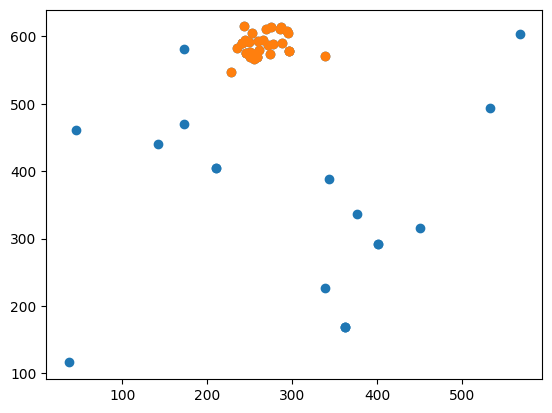

In [11]:
print(templates[0][1])
sift = cv2.SIFT_create()
keypoints_train = extract_keypoint(templates[0], s_img, sift)
# print(keypoints_train)
print(len(keypoints_train))
plt.scatter(keypoints_train[:, 0], keypoints_train[:, 1])

cluster_labels = cluster_keypoints(keypoints_train)
print(cluster_labels)
cluster_labels_filtered = retrieve_relevant_points(keypoints_train, cluster_labels)
print(cluster_labels_filtered)
plt.scatter(np.array(cluster_labels_filtered)[:, 0], np.array(cluster_labels_filtered)[:, 1])

In [38]:
def get_pixel_average(coords):
    if len(coords) == 0:
        return np.array([])
    return np.average(coords, axis=0)

Iteration 0/1000


C:\Users\lucah\AppData\Local\Temp\ipykernel_23316\2161241169.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


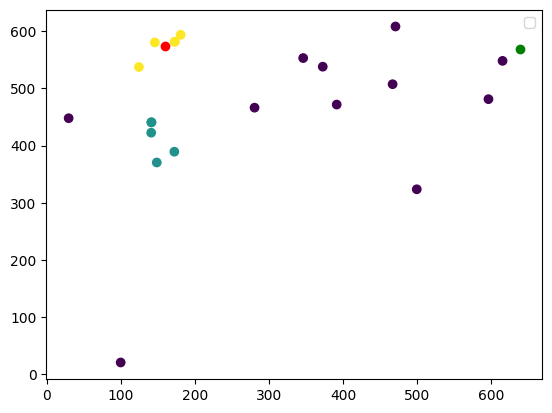

Iteration 50/1000


C:\Users\lucah\AppData\Local\Temp\ipykernel_23316\2161241169.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


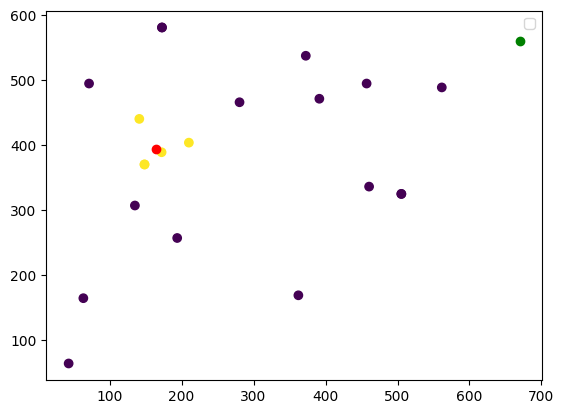

C:\Users\lucah\AppData\Local\Temp\ipykernel_23316\2161241169.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


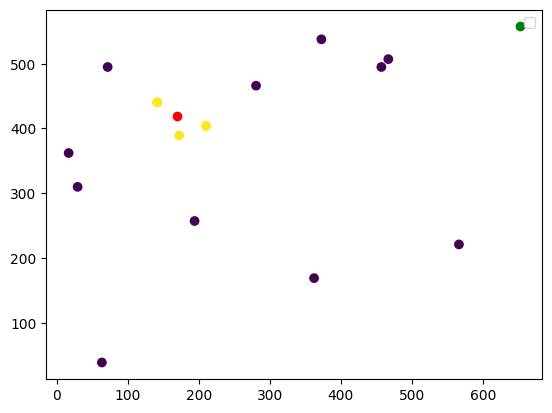

C:\Users\lucah\AppData\Local\Temp\ipykernel_23316\2161241169.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


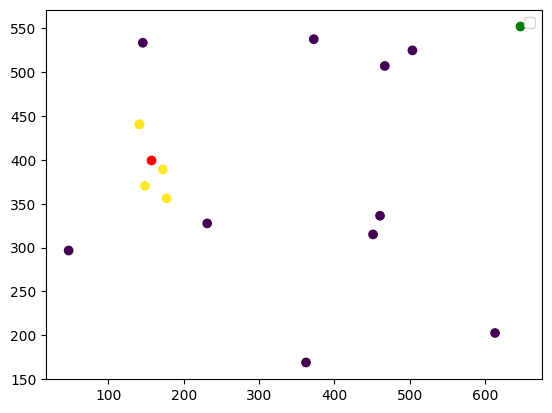

Iteration 100/1000
Iteration 150/1000
Average distance from pixel: 68.0849858865992
Empty points: 7
Distance too large: 4


In [44]:
from haversine import haversine, Unit

distance = 0
# templates_selection = templates
sift = cv2.SIFT_create()
empty_points = 0
distance_too_large = 0


for i, template in enumerate(templates[:200]):
    if i % 50 == 0:
        print(f"Iteration {i}/{len(templates)}")

    keys = extract_keypoint(template, s_img, sift)
    labels = cluster_keypoints(keys)
    points = retrieve_relevant_points(keys, labels)
    avg_points = get_pixel_average(points)
    if len(points) == 0:
        empty_points += 1
        # print(keys)
        # print(labels)
        # print(points)
        # print(avg_points)
        # plt.scatter(keys[:, 0], keys[:, 1])
        # plt.show()
        continue

    predicted_coords = PxltoCoord(avg_points[0], avg_points[1], 15, 51.999080, 4.373749)
    actual_coords = template[1]['gps_coords']
    distance += haversine(predicted_coords, actual_coords, unit=Unit.METERS)
    if haversine(predicted_coords, actual_coords, unit=Unit.METERS) > 200:
        distance_too_large += 1
        actual_pixel = CoordToPixel(actual_coords[0], actual_coords[1], 51.999080, 4.373749, 15)
        plt.scatter(keys[:, 0], keys[:, 1], c=labels)
        plt.legend()
        plt.scatter(avg_points[0], avg_points[1], c='r')
        plt.scatter(actual_pixel[0], actual_pixel[1], c='g')
        plt.show()

    # print(haversine(predicted_coords, actual_coords, unit=Unit.METERS))

average_distance = distance/(len(templates[:200])-empty_points-distance_too_large)
print(f"Average distance from pixel: {average_distance}")
print(f"Empty points: {empty_points}")
print(f"Distance too large: {distance_too_large}")
